# Privacy-Preserving Record Linkage (PPRL): Investigating Dataset Extension Attacks

In [1]:
import os

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision

from utils import *

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import hickle as hkl
import numpy as np
import string
import sys
from tqdm.notebook import tqdm

from graphMatching.gma import run_gma

from datasets.bloom_filter_dataset_reversed import BloomFilterDatasetReversed
from datasets.tab_min_hash_dataset import TabMinHashDataset
from datasets.two_step_hash_dataset import TwoStepHashDataset

from pytorch_models.bloom_filter_to_two_gram_classifier import BloomFilterToTwoGramClassifier
from pytorch_models.tab_min_hash_to_two_gram_classifier import TabMinHashToTwoGramClassifier
from pytorch_models.two_step_hash_to_two_gram_classifier import TwoStepHashToTwoGramClassifier

from early_stopping.early_stopping import EarlyStopping

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

Using NumPy dot (Mac)
System Version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:20:01) [Clang 18.1.8 ]
PyTorch version 2.1.2
Torchvision version 0.16.2
Numpy version 1.24.4
Pandas version 2.0.3


In [2]:
# Parameters
GLOBAL_CONFIG = {
    "Data": "./data/datasets/fakename_1k.tsv",
    "Overlap": 0.8,
    "DropFrom": "Eve",
    "Verbose": True,  # Print Status Messages
    "MatchingMetric": "cosine",
    "Matching": "MinWeight",
    "Workers": -1,
    "SaveAliceEncs": False,
    "SaveEveEncs": False,
    "DevMode": False,
}


DEA_CONFIG = {
    "DevMode": False,
    # BCEWithLogitsLoss / MultiLabelSoftMarginLoss
    "LossFunction:": "BCEWithLogitsLoss",
    # Adam / AdamW / SGD / RMSprop
    "Optimizer": "Adam",
    "LearningRate": 0.001,
    # SGD only
    "Momentum": 0.9,
    "BatchSize": 16,
    "Epochs": 20,
    # TestSize calculated accordingly
    "TrainSize": 0.8,
    "FilterThreshold": 0.5,
    "Patience": 5,
    "MinDelta": 0.001,
}

ENC_CONFIG = {
    # TwoStepHash / TabMinHash / BloomFilter
    "AliceAlgo": "BloomFilter",
    "AliceSecret": "SuperSecretSalt1337",
    "AliceN": 2,
    "AliceMetric": "dice",
    "EveAlgo": "None",
    "EveSecret": "ATotallyDifferentString42",
    "EveN": 2,
    "EveMetric": "dice",
    # For BF encoding
    "AliceBFLength": 1024,
    "AliceBits": 10,
    "AliceDiffuse": False,
    "AliceT": 10,
    "AliceEldLength": 1024,
    "EveBFLength": 1024,
    "EveBits": 10,
    "EveDiffuse": False,
    "EveT": 10,
    "EveEldLength": 1024,
    # For TMH encoding
    "AliceNHash": 1024,
    "AliceNHashBits": 64,
    "AliceNSubKeys": 8,
    "Alice1BitHash": True,
    "EveNHash": 1024,
    "EveNHashBits": 64,
    "EveNSubKeys": 8,
    "Eve1BitHash": True,
    # For 2SH encoding
    "AliceNHashFunc": 10,
    "AliceNHashCol": 1000,
    "AliceRandMode": "PNG",
    "EveNHashFunc": 10,
    "EveNHashCol": 1000,
    "EveRandMode": "PNG",
}

EMB_CONFIG = {
    "Algo": "Node2Vec",
    "AliceQuantile": 0.9,
    "AliceDiscretize": False,
    "AliceDim": 128,
    "AliceContext": 10,
    "AliceNegative": 1,
    "AliceNormalize": True,
    "EveQuantile": 0.9,
    "EveDiscretize": False,
    "EveDim": 128,
    "EveContext": 10,
    "EveNegative": 1,
    "EveNormalize": True,
    # For Node2Vec
    "AliceWalkLen": 100,
    "AliceNWalks": 20,
    "AliceP": 250,
    "AliceQ": 300,
    "AliceEpochs": 5,
    "AliceSeed": 42,
    "EveWalkLen": 100,
    "EveNWalks": 20,
    "EveP": 250,
    "EveQ": 300,
    "EveEpochs": 5,
    "EveSeed": 42
}

ALIGN_CONFIG = {
    "RegWS": max(0.1, GLOBAL_CONFIG["Overlap"]/2), #0005
    "RegInit":1, # For BF 0.25
    "Batchsize": 1, # 1 = 100%
    "LR": 200.0,
    "NIterWS": 100,
    "NIterInit": 5 ,  # 800
    "NEpochWS": 100,
    "LRDecay": 1,
    "Sqrt": True,
    "EarlyStopping": 10,
    "Selection": "None",
    "MaxLoad": None,
    "Wasserstein": True
}

In [3]:
# Get unique hash identifiers for the encoding and embedding configurations
eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash = get_hashes(GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG)

# Define file paths based on the configuration hashes
path_reidentified = f"./data/available_to_eve/reidentified_individuals_{eve_enc_hash}_{alice_enc_hash}_{eve_emb_hash}_{alice_emb_hash}.h5"
path_not_reidentified = f"./data/available_to_eve/not_reidentified_individuals_{eve_enc_hash}_{alice_enc_hash}_{eve_emb_hash}_{alice_emb_hash}.h5"
path_all = f"./data/dev/alice_data_complete_with_encoding_{eve_enc_hash}_{alice_enc_hash}_{eve_emb_hash}_{alice_emb_hash}.h5"

# Check if the output files already exist
if os.path.isfile(path_reidentified) and os.path.isfile(path_not_reidentified) and os.path.isfile(path_all):
    # Load previously saved attack results
    print("Loading previously saved attack results...")
    reidentified_data = hkl.load(path_reidentified)
    not_reidentified_data = hkl.load(path_not_reidentified)
    all_data = hkl.load(path_all)

else:
    # Run Graph Matching Attack if files are not found
    reidentified_data, not_reidentified_data, all_data = run_gma(
        GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG, ALIGN_CONFIG, DEA_CONFIG,
        eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash
    )

# Convert lists to DataFrames
df_reidentified = pd.DataFrame(reidentified_data[1:], columns=reidentified_data[0])
df_not_reidentified = pd.DataFrame(not_reidentified_data[1:], columns=not_reidentified_data[0])
df_all = pd.DataFrame(all_data[1:], columns=all_data[0])

Loading previously saved attack results...


In [4]:
# --- Generate a dictionary of all possible 2-grams from letters and digits ---

# Lowercase alphabet: 'a' to 'z'
alphabet = string.ascii_lowercase

# Digits: '0' to '9'
digits = string.digits

# Generate all letter-letter 2-grams (e.g., 'aa', 'ab', ..., 'zz')
letter_letter_grams = [a + b for a in alphabet for b in alphabet]

# Generate all digit-digit 2-grams (e.g., '00', '01', ..., '99')
digit_digit_grams = [d1 + d2 for d1 in digits for d2 in digits]

# Generate all letter-digit 2-grams (e.g., 'a0', 'a1', ..., 'z9')
letter_digit_grams = [l + d for l in alphabet for d in digits]

# Combine all generated 2-grams into one list
all_two_grams = letter_letter_grams + letter_digit_grams + digit_digit_grams

# Create a dictionary mapping index to each 2-gram
two_gram_dict = {i: two_gram for i, two_gram in enumerate(all_two_grams)}

In [5]:
# 1️ Bloom Filter Encoding
if ENC_CONFIG["AliceAlgo"] == "BloomFilter":
    data_labeled = BloomFilterDatasetReversed(
        df_reidentified,
        is_labeled=True,
        all_two_grams=all_two_grams,
    )
    data_not_labeled = BloomFilterDatasetReversed(
        df_not_reidentified,
        is_labeled=False,
        all_two_grams=all_two_grams,
    )
    bloomfilter_length = len(df_reidentified["bloomfilter"][0])

# 2️ Tabulation MinHash Encoding
elif ENC_CONFIG["AliceAlgo"] == "TabMinHash":
    data_labeled = TabMinHashDataset(
        df_reidentified,
        is_labeled=True,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )
    data_not_labeled = TabMinHashDataset(
        df_not_reidentified,
        is_labeled=False,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )
    tabminhash_length = len(df_reidentified["tabminhash"][0])

# 3 Two-Step Hash Encoding (One-Hot Encoding Mode)
elif ENC_CONFIG["AliceAlgo"] == "TwoStepHash":
    # Collect all unique integers across both reidentified and non-reidentified data
    unique_ints_reid = set().union(*df_reidentified["twostephash"])
    unique_ints_not_reid = set().union(*df_not_reidentified["twostephash"])
    unique_ints_sorted = sorted(unique_ints_reid.union(unique_ints_not_reid))
    unique_integers_dict = {i: val for i, val in enumerate(unique_ints_sorted)}

    data_labeled = TwoStepHashDataset(
        df_reidentified,
        is_labeled=True,
        all_integers=unique_ints_sorted,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )
    data_not_labeled = TwoStepHashDataset(
        df_not_reidentified,
        is_labeled=False,
        all_integers=unique_ints_sorted,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )

In [6]:
# Define dataset split proportions
train_size = int(DEA_CONFIG["TrainSize"] * len(data_labeled))
val_size = len(data_labeled) - train_size

# Split the reidentified dataset into training and validation sets
data_train, data_val = random_split(data_labeled, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
dataloader_train = DataLoader(
    data_train,
    batch_size=DEA_CONFIG["BatchSize"],
    shuffle=True  # Important for training
)

dataloader_val = DataLoader(
    data_val,
    batch_size=DEA_CONFIG["BatchSize"],
    shuffle=True  # Allows variation in validation batches
)

dataloader_test = DataLoader(
    data_not_labeled,
    batch_size=DEA_CONFIG["BatchSize"],
    shuffle=True
)

In [7]:
# Instantiate model based on selected encoding scheme
if ENC_CONFIG["AliceAlgo"] == "BloomFilter":
    model = BloomFilterToTwoGramClassifier(
        input_dim=len(all_two_grams),
        output_dim=bloomfilter_length
    )

elif ENC_CONFIG["AliceAlgo"] == "TabMinHash":
    model = TabMinHashToTwoGramClassifier(
        input_dim=len(all_two_grams),
        output_dim=tabminhash_length
    )

elif ENC_CONFIG["AliceAlgo"] == "TwoStepHash":
    model = TabMinHashToTwoGramClassifier(
        input_dim=len(all_two_grams),
        output_dim=len(unique_ints_sorted)
    )

In [8]:
# Setup tensorboard logging
run_name = "".join([
    DEA_CONFIG["LossFunction:"],
    DEA_CONFIG["Optimizer"],
    ENC_CONFIG["AliceAlgo"],
])
tb_writer = SummaryWriter(f"runs/{run_name}")

# Setup compute device (GPU/CPU)
compute_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(compute_device)

# Initialize loss function
match DEA_CONFIG["LossFunction:"]:
    case "BCEWithLogitsLoss":
        criterion = nn.BCEWithLogitsLoss(reduction='mean')
    case "MultiLabelSoftMarginLoss":
        criterion = nn.MultiLabelSoftMarginLoss(reduction='mean')
    case _:
        raise ValueError(f"Unsupported loss function: {DEA_CONFIG['LossFunction:']}")

# Initialize optimizer
match DEA_CONFIG["Optimizer"]:
    case "Adam":
        optimizer = optim.Adam(model.parameters(), lr=DEA_CONFIG["LearningRate"])
    case "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=DEA_CONFIG["LearningRate"])
    case "SGD":
        optimizer = optim.SGD(model.parameters(),
                            lr=DEA_CONFIG["LearningRate"],
                            momentum=DEA_CONFIG["Momentum"])
    case "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=DEA_CONFIG["LearningRate"])
    case _:
        raise ValueError(f"Unsupported optimizer: {DEA_CONFIG['Optimizer']}")

In [9]:
def train_model(model, dataloader_train, dataloader_val, criterion, optimizer, device):
    train_losses, val_losses = [], []
    early_stopper = EarlyStopping(patience=DEA_CONFIG["Patience"], min_delta=DEA_CONFIG["MinDelta"])

    for epoch in range(DEA_CONFIG["Epochs"]):
        # Training phase
        model.train()
        train_loss = run_epoch(
            model, dataloader_train, criterion, optimizer,
            device, is_training=True
        )
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = run_epoch(
            model, dataloader_val, criterion, optimizer,
            device, is_training=False
        )
        val_losses.append(val_loss)

        # Logging
        log_metrics(train_loss, val_loss, epoch, DEA_CONFIG["Epochs"])

        # Early stopping check
        if early_stopper(val_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    return train_losses, val_losses

def run_epoch(model, dataloader, criterion, optimizer, device, is_training):
    running_loss = 0.0
    with torch.set_grad_enabled(is_training):
        for data, labels, _ in tqdm(dataloader,
                                  desc="Training" if is_training else "Validation"):
            data, labels = data.to(device), labels.to(device)

            if is_training:
                optimizer.zero_grad()

            outputs = model(data)
            loss = criterion(outputs, labels)

            if is_training:
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * labels.size(0)

    return running_loss / len(dataloader.dataset)

def log_metrics(train_loss, val_loss, epoch, total_epochs):
    print(f"Epoch {epoch + 1}/{total_epochs} - "
          f"Train loss: {train_loss:.4f}, "
          f"Validation loss: {val_loss:.4f}")
    tb_writer.add_scalar("Loss/train", train_loss, epoch + 1)
    tb_writer.add_scalar("Loss/validation", val_loss, epoch + 1)

train_losses, val_losses = train_model(
    model, dataloader_train, dataloader_val,
    criterion, optimizer, compute_device
    )

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/20 - Train loss: 0.4828, Validation loss: 0.4166
best_loss updated from  inf  to  0.4166346251964569


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/20 - Train loss: 0.4137, Validation loss: 0.4106
best_loss updated from  0.4166346251964569  to  0.41062030494213103


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/20 - Train loss: 0.4093, Validation loss: 0.4080
best_loss updated from  0.41062030494213103  to  0.4080361187458038


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/20 - Train loss: 0.4049, Validation loss: 0.4032
best_loss updated from  0.4080361187458038  to  0.4032308131456375


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/20 - Train loss: 0.3941, Validation loss: 0.3902
best_loss updated from  0.4032308131456375  to  0.390218111872673


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/20 - Train loss: 0.3699, Validation loss: 0.3703
best_loss updated from  0.390218111872673  to  0.3702801465988159


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/20 - Train loss: 0.3442, Validation loss: 0.3540
best_loss updated from  0.3702801465988159  to  0.3540319502353668


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/20 - Train loss: 0.3216, Validation loss: 0.3398
best_loss updated from  0.3540319502353668  to  0.33982694447040557


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/20 - Train loss: 0.3020, Validation loss: 0.3298
best_loss updated from  0.33982694447040557  to  0.32977530658245086


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/20 - Train loss: 0.2860, Validation loss: 0.3206
best_loss updated from  0.32977530658245086  to  0.32061841487884524


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/20 - Train loss: 0.2708, Validation loss: 0.3144
best_loss updated from  0.32061841487884524  to  0.31437515616416933


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/20 - Train loss: 0.2576, Validation loss: 0.3076
best_loss updated from  0.31437515616416933  to  0.3075788408517838


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/20 - Train loss: 0.2462, Validation loss: 0.3018
best_loss updated from  0.3075788408517838  to  0.30183480083942416


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/20 - Train loss: 0.2341, Validation loss: 0.2965
best_loss updated from  0.30183480083942416  to  0.29648575484752654


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/20 - Train loss: 0.2243, Validation loss: 0.2929
best_loss updated from  0.29648575484752654  to  0.2929284512996674


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/20 - Train loss: 0.2137, Validation loss: 0.2889
best_loss updated from  0.2929284512996674  to  0.28894869685173036


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/20 - Train loss: 0.2057, Validation loss: 0.2853
best_loss updated from  0.28894869685173036  to  0.2852890074253082


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/20 - Train loss: 0.1968, Validation loss: 0.2827
best_loss updated from  0.2852890074253082  to  0.2826510727405548


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/20 - Train loss: 0.1883, Validation loss: 0.2798
best_loss updated from  0.2826510727405548  to  0.2798235833644867


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/20 - Train loss: 0.1820, Validation loss: 0.2770
best_loss updated from  0.2798235833644867  to  0.2770300775766373


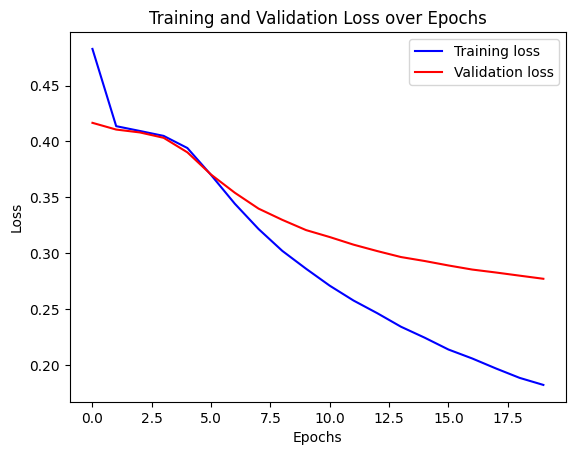

In [10]:
# Plot the training and validation losses over epochs
plt.plot(train_losses, label='Training loss', color='blue')
plt.plot(val_losses, label='Validation loss', color='red')

# Adding a legend to the plot
plt.legend()

# Setting the title and labels for clarity
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Show the plot
plt.show()

In [11]:
# List to store decoded 2-gram scores for all test samples
decoded_test_results_words = []
combined_results_performance = []

# Switch to evaluation mode (no gradient computation during inference)
model.eval()

# Define Threshold for filtering predictions
threshold = DEA_CONFIG["FilterThreshold"]

# Loop through the test dataloader for inference
with torch.no_grad():  # No need to compute gradients during inference
    for data_batch, uids in tqdm(dataloader_test, desc="Test loop"):
        # Filter relevant individuals from the dataset based on UIDs
        filtered_df = df_all[df_all["uid"].isin(uids)].drop(df_all.columns[-2], axis=1) # Drop encoding column

        # Extract 2-grams from actual data for comparison
        actual_two_grams_batch = []
        for _, entry in filtered_df.iterrows():
            row = entry[:-1]  # Exclude UID from row
            extracted_two_grams = extract_two_grams("".join(map(str, row)))  # Extract 2-grams from the row
            actual_two_grams_batch.append({"uid": entry["uid"], "two_grams": extracted_two_grams})

        # Move the batch of data to the device (e.g., GPU)
        data_batch = data_batch.to(compute_device)

        # Apply the model to get logits (raw predictions)
        logits = model(data_batch)

        # Convert logits to probabilities using sigmoid (binary classification)
        probabilities = torch.sigmoid(logits)

        # Convert probabilities into 2-gram scores (using the two_gram_dict to map to 2-gram labels)
        batch_two_gram_scores = [
            {two_gram_dict[j]: score.item() for j, score in enumerate(probabilities[i])}  # Map each probability to its 2-gram
            for i in range(probabilities.size(0))  # Iterate over each sample in the batch
        ]

        # Apply threshold to filter out low-scoring 2-grams
        batch_filtered_two_gram_scores = [
            {two_gram: score for two_gram, score in two_gram_scores.items() if score > threshold}  # Only keep scores above threshold
            for two_gram_scores in batch_two_gram_scores
        ]

        # Filtered 2-grams per UID in the batch
        filtered_two_grams = [
            {"uid": uid, "two_grams": {key for key in two_grams.keys()}}  # Only keep the 2-gram keys (no scores)
            for uid, two_grams in zip(uids, batch_filtered_two_gram_scores)
        ]

        # Reconstruct words from the filtered 2-grams for each sample
        batch_reconstructed_words = [
            reconstruct_words(filtered_scores) for filtered_scores in batch_filtered_two_gram_scores
        ]

        # Append the reconstructed words to the results list
        decoded_test_results_words.extend(batch_reconstructed_words)

        # Compare predicted 2-grams with actual 2-grams and calculate performance metrics
        for entry_two_grams_batch in actual_two_grams_batch:  # Loop through each UID in the batch
            for entry_filtered_two_grams in filtered_two_grams:
                if entry_two_grams_batch["uid"] == entry_filtered_two_grams["uid"]:
                    # Calculate Dice similarity between actual and predicted 2-grams
                    combined_results_performance.append({
                        "uid": entry_two_grams_batch["uid"],
                        "actual_two_grams": entry_two_grams_batch["two_grams"],  # Get actual 2-grams for this UID
                        "predicted_two_grams": entry_filtered_two_grams["two_grams"],  # Get predicted 2-grams for this UID
                        "dice_similarity": dice_coefficient(entry_two_grams_batch["two_grams"], entry_filtered_two_grams["two_grams"]),
                    })

# Now `combined_results_performance` contains detailed comparison for all test samples
print(combined_results_performance)


Test loop:   0%|          | 0/13 [00:00<?, ?it/s]

[{'uid': '72100', 'actual_two_grams': ['he', 'er', 'rm', 'ma', 'an', 'nz', 'zi', 'ie', 'em', 'me', 'er', 'r3', '33', '31', '19', '95', '52'], 'predicted_two_grams': {'io', 'pb', 'w9', 'ne', 'w7', 'wd', 'cj', '29', 'f8', 'tj', 'mf', 'p1', 'fx', 'p4', 'cd', 'mi', 's9', 'hb', 'ug', 'p2', 'p8', 'sw', 'k8', 'ld', 'dq', 'k1', 'xa', 'f9', 'l5', 'eg', 'r9', '35', 'bo', 'g9', 'i3'}, 'dice_similarity': 0.0}, {'uid': '87747', 'actual_two_grams': ['ja', 'ac', 'ck', 'ki', 'ie', 'eg', 'gr', 're', 'ee', 'en', 'nb', 'ba', 'au', 'um', 'm1', '10', '01', '15', '51', '19', '99', '94'], 'predicted_two_grams': {'io', 'pb', 'w9', 'ne', 'w7', 'wd', 'cj', '29', 'f8', 'tj', 'mf', 'p1', 'fx', 'p4', 'cd', 'mi', 's9', 'hb', 'ug', 'p2', 'p8', 'sw', 'k8', 'ld', 'dq', 'k1', 'xa', 'f9', 'l5', 'eg', 'r9', '35', 'bo', 'g9', 'i3'}, 'dice_similarity': 0.0351}, {'uid': '31833', 'actual_two_grams': ['li', 'il', 'll', 'li', 'ia', 'an', 'na', 'al', 'll', 'le', 'en', 'n8', '82', '23', '31', '19', '93', '39'], 'predicted_two_gr